<a href="https://colab.research.google.com/github/Anjalin01/Image-Enhancement-using-CNN/blob/main/Image_Enhancement_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anjalin Anna Cherian<br>


##Image Enhancement using CNN

<P>A convolutional neural network (CNN or ConvNet), is a network architecture for deep learning which learns directly from data, eliminating the need for manual feature extraction. A ConvNet is able to successfully capture the Spatial and Temporal dependencies in an image through the application of relevant filters.<br>
<p>The aim of the this assignment is to enhance an image using CNN. Inorder to do this we define a model, train it and also make use of auto encoders to enhance the resolution of the images.


INITIALIZATIONS

In [ ]:
#Importing the required libraries
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the dataset file lwn which consist of multiple directories and is basically a database of face photographs 
face_images = glob.glob('/content/drive/MyDrive/lfwn (1)/**/*.jpg') #capturing all .jpg images from the directories.
print(len(face_images)) #printing the number of images present

2264


LOADING AND PREPROCESSING THE IMAGES

In [ ]:
# Using multiprocessing library to reduce processing time 
# Importing pool object which offers a convenient means of parallelizing the execution of a function across multiple input values(data parallelism).
from multiprocessing import Pool
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  return img
p = Pool(10) 
img_array = p.map(read, face_images) # using pool.map to pass list of multiple arguments(images)to the function

In [ ]:
#pickling img_array so that it can be saved on disk and time can be saved in the future
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)
print(len(img_array))

2264


In [ ]:
import numpy as np
all_images = np.array(img_array)

In [ ]:
#Splitting into test and train data
x_train, x_test = train_test_split(all_images, random_state = 32, test_size=0.2)

In [ ]:
x_train.shape

(1811, 80, 80, 3)

In [ ]:
x_test.shape

(453, 80, 80, 3)

In [ ]:
#To lower resolution without changing the size of the images taken to be as input

def pixalate_image(image, scale_percent = 40):
  #reducing the resolution of each pixel by the scale_percent taken
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  # We use cv2.resize for resizing the image and this helps in in reducing the number of pixels from an image
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
  return low_res_image 

In [ ]:
x_train_px = []
for i in range(x_train.shape[0]):
  temp = pixalate_image(x_train[i,:,:,:])
  x_train_px.append(temp) 
x_train_px = np.array(x_train_px)   #Converting into array of Distorted images
# getting low resolution images for the test set
x_test_px = []
for i in range(x_test.shape[0]):
  temp = pixalate_image(x_train[i,:,:,:]) #Distorting the images from the test set
  x_test_px.append(temp)
x_test_px = np.array(x_test_px)     #Distorted images

BUILDING OUR MODEL

In [ ]:
# The inputs are 80x80 RGB images and the batch size is 3.
Input_img = Input(shape=(80, 80, 3))  
Input_img

<KerasTensor: shape=(None, 80, 80, 3) dtype=float32 (created by layer 'input_5')>

In [ ]:
#Activation function we are using is relu()
#Keeping padding="same" so that the output has the same size as the input.
#The regularizer function applied to the kernel weights matrix is l1 regularisation technique which is best in avoiding overfitting

x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img) 
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

In [ ]:
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)


In [ ]:
# Increasing the dimensions by Upsampling 
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

In [ ]:
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 80, 80, 64)   1792        ['input_5[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 80, 80, 64)   36928       ['conv2d_12[0][0]']              
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 40, 40, 64)  0           ['conv2d_13[0][0]']              
                                                                                            

TRAINING OUR MODEL

In [ ]:
#Defining some callbacks for model visualization and evaluation
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
#Training the model with 10 epochs
history = autoencoder.fit(x_train_px,x_train,
            epochs=10,
            validation_data=(x_test_px,x_test),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/10
57/57 [==============================] - 637s 11s/step - loss: 0.0275 - accuracy: 0.6877 - val_loss: 0.1451 - val_accuracy: 0.5063
Epoch 2/10
57/57 [==============================] - 608s 11s/step - loss: 0.0041 - accuracy: 0.8650 - val_loss: 0.1455 - val_accuracy: 0.5339
Epoch 3/10
57/57 [==============================] - 606s 11s/step - loss: 0.0035 - accuracy: 0.8779 - val_loss: 0.1479 - val_accuracy: 0.5363
Epoch 4/10
57/57 [==============================] - 605s 11s/step - loss: 0.0032 - accuracy: 0.8811 - val_loss: 0.1473 - val_accuracy: 0.5273
Epoch 5/10
57/57 [==============================] - 599s 11s/step - loss: 0.0031 - accuracy: 0.8876 - val_loss: 0.1471 - val_accuracy: 0.5404
Epoch 6/10
57/57 [==============================] - 601s 11s/step - loss: 0.0030 - accuracy: 0.8892 - val_loss: 0.1485 - val_accuracy: 0.5358
Epoch 7/10
57/57 [==============================] - 599s 11s/step - loss: 0.0028 - accuracy: 0.8971 - val_loss: 0.1478 - val_accuracy: 0.5288
Epoch 

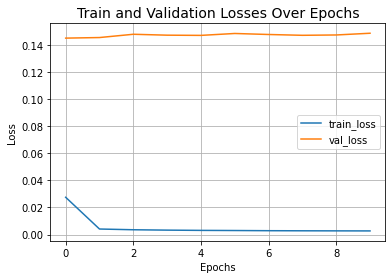

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


EVALUATING THE MODEL

In [ ]:
#Model Evaluation
results = autoencoder.evaluate(x_test_px, x_test)
print('val_loss, val_accuracy', results)

15/15 [==============================] - 36s 2s/step - loss: 0.1487 - accuracy: 0.5329
loss, accuracy [0.14869393408298492, 0.5328738689422607]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


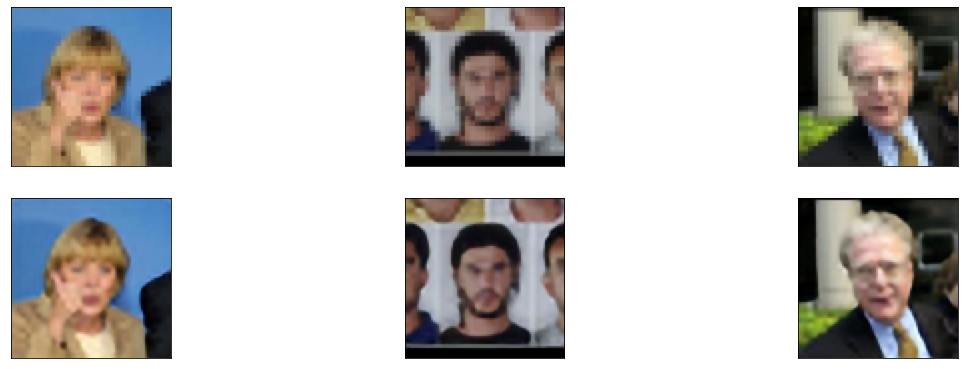

In [ ]:
# Making predictions and obtaining the output
predictions = autoencoder.predict(x_test_px)
n = 3
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(x_test_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()